Determining map size...
 sTopol first round done
Map size [44, 30]
Initialization...
 sTopol first round done
Training using batch algorithm...
Rough training phase...
Training: 1 / 4 s

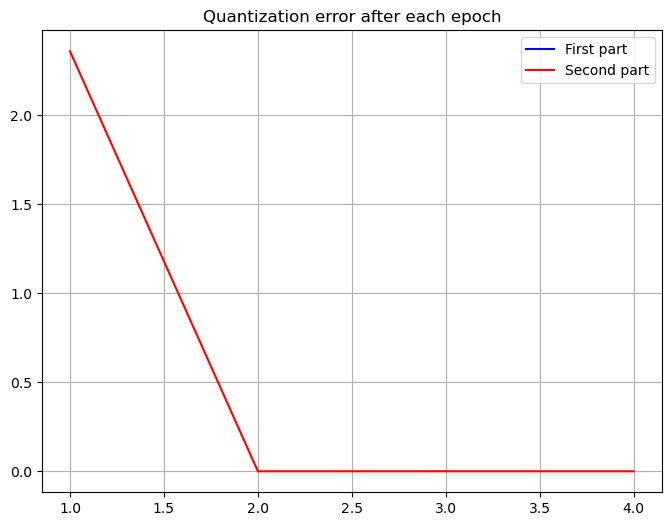

Training: 2 / 5 s

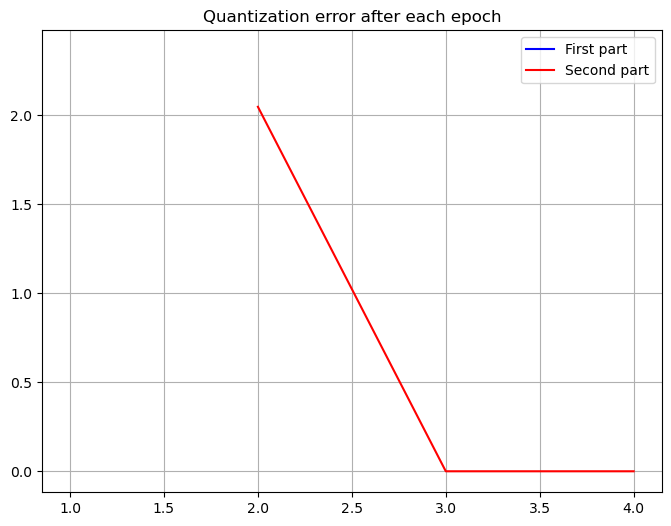

Training: 4 / 5 s

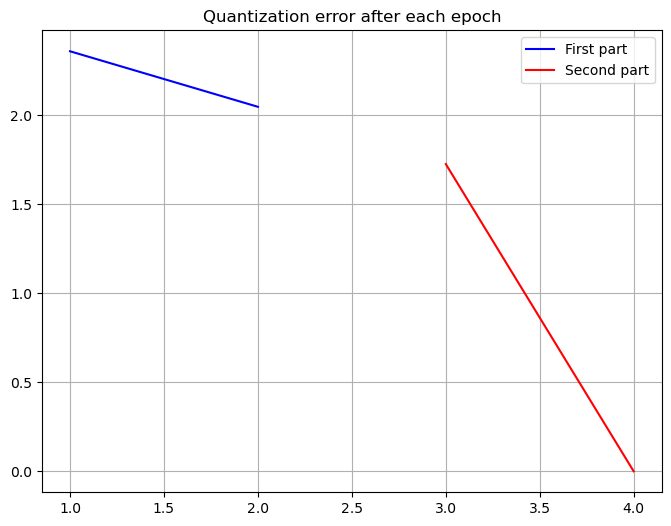

Training: 5 / 5 s

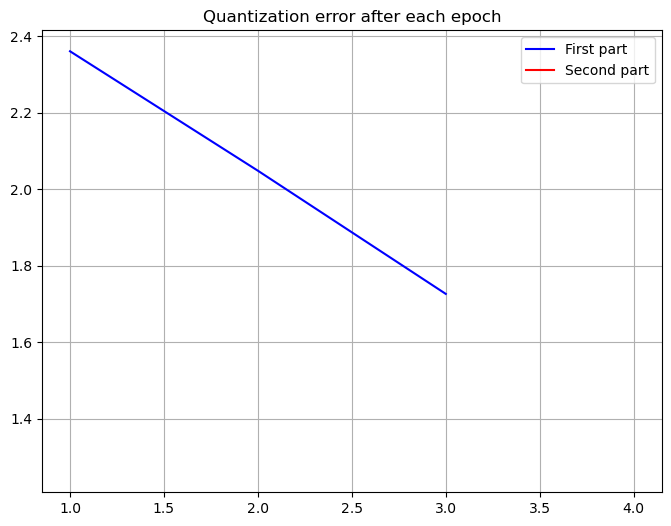



finetuning phase...
Training: 1 / 4 s

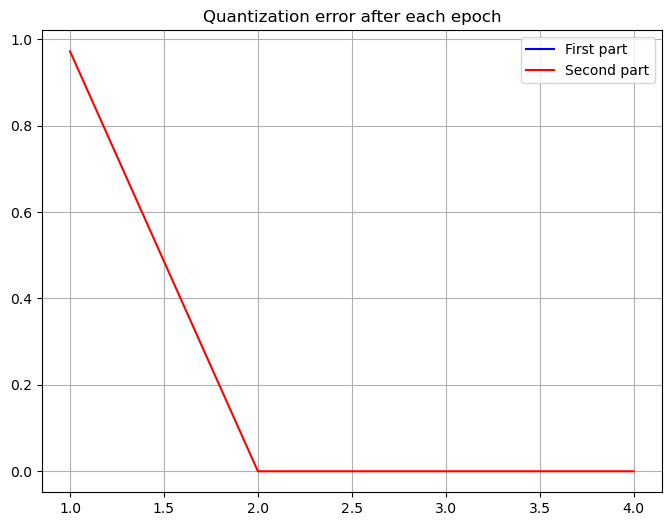

Training: 2 / 5 s

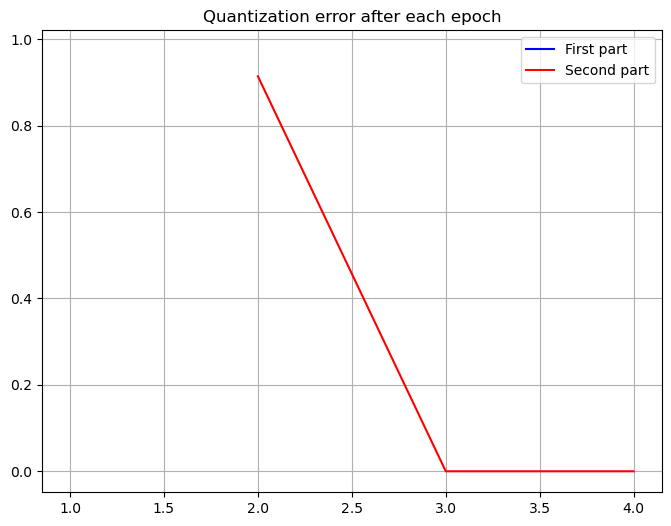

Training: 4 / 5 s

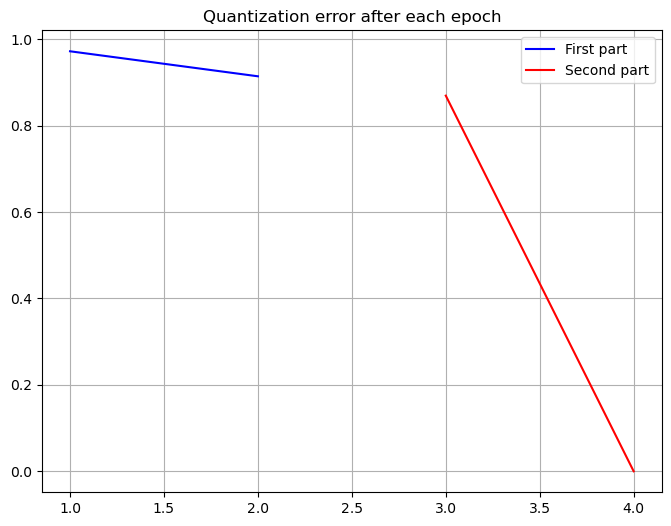

Training: 5 / 5 s

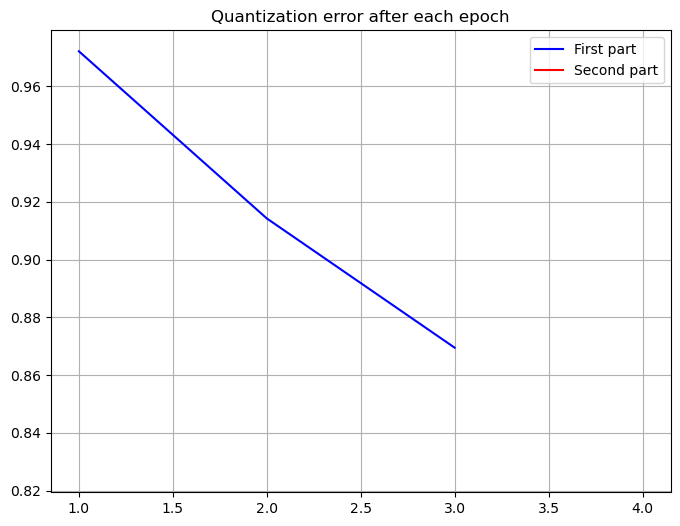



Final quantization error: 0.785
Final topographic error:  0.054


c:\Users\Tijn\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Tijn\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


MEAN_train range: X(12.0 to 26.0), Y(3.0 to 26.0)
MEAN_test range: X(20.0 to 37.0), Y(3.0 to 29.0)
FRAMES_re shape: (44, 30)


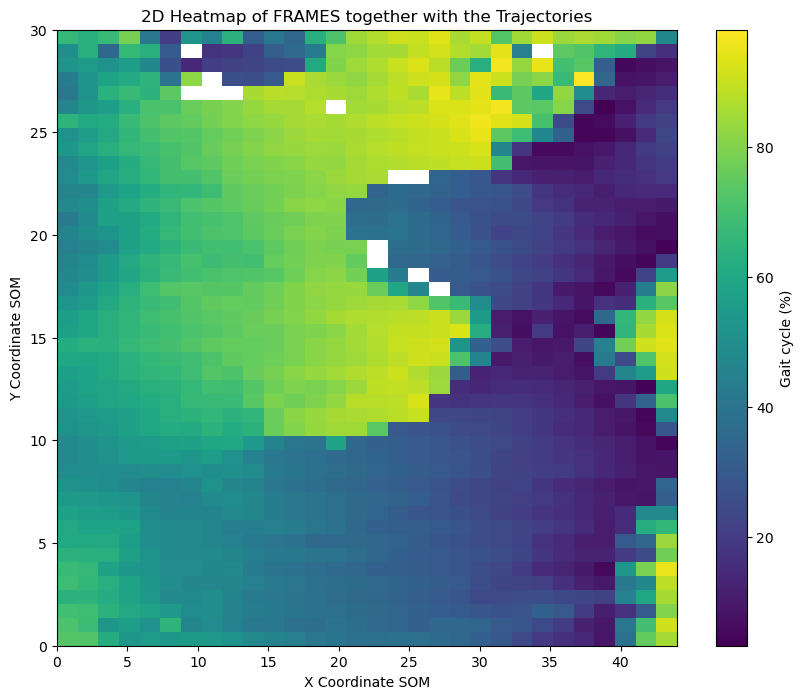

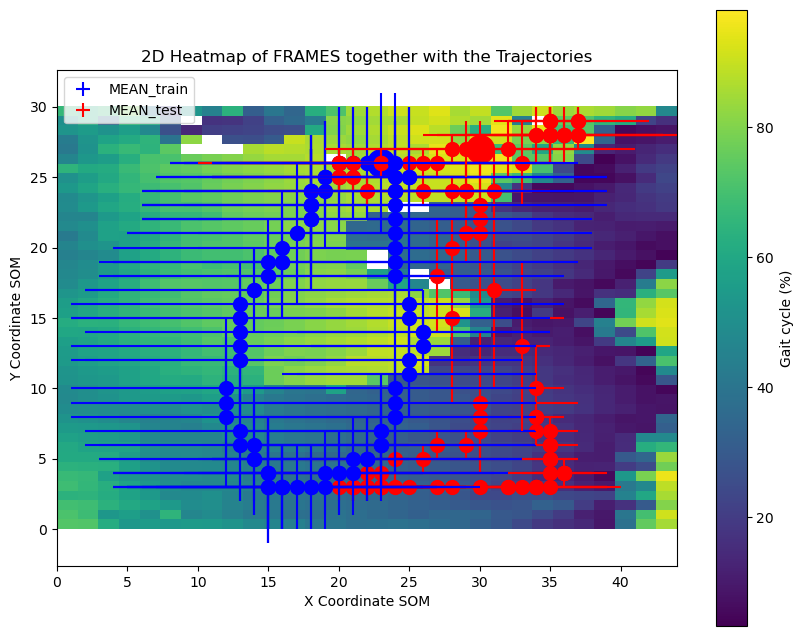

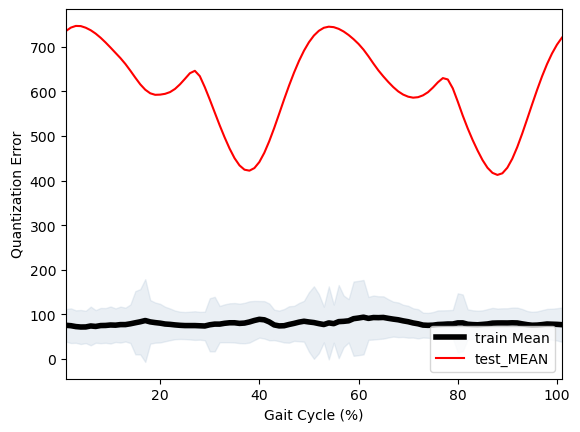

c:\Users\Tijn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tijn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


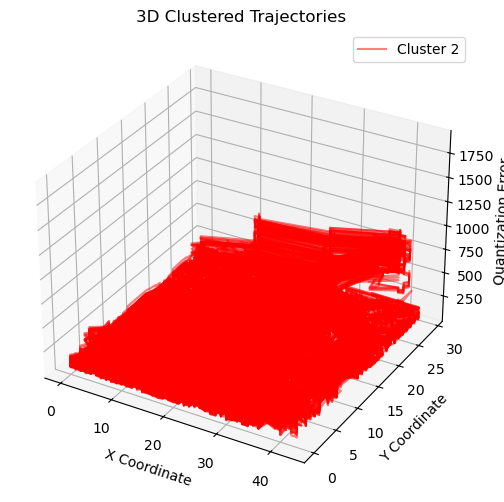

Cluster assignments:
Data1 slice 0 is in Cluster 2
Data1 slice 1 is in Cluster 2
Data1 slice 2 is in Cluster 2
Data1 slice 3 is in Cluster 2
Data1 slice 4 is in Cluster 2
Data1 slice 5 is in Cluster 2
Data1 slice 6 is in Cluster 2
Data1 slice 7 is in Cluster 2
Data1 slice 8 is in Cluster 2
Data1 slice 9 is in Cluster 2
Data1 slice 10 is in Cluster 2
Data1 slice 11 is in Cluster 2
Data1 slice 12 is in Cluster 2
Data1 slice 13 is in Cluster 2
Data1 slice 14 is in Cluster 2
Data1 slice 15 is in Cluster 2
Data1 slice 16 is in Cluster 2
Data1 slice 17 is in Cluster 2
Data1 slice 18 is in Cluster 2
Data1 slice 19 is in Cluster 2
Data1 slice 20 is in Cluster 2
Data1 slice 21 is in Cluster 2
Data1 slice 22 is in Cluster 2
Data1 slice 23 is in Cluster 2
Data1 slice 24 is in Cluster 2
Data1 slice 25 is in Cluster 2
Data1 slice 26 is in Cluster 2
Data1 slice 27 is in Cluster 2
Data1 slice 28 is in Cluster 2
Data1 slice 29 is in Cluster 2
Data1 slice 30 is in Cluster 2
Data1 slice 31 is in Cluster

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 10 10:00:25 2024

@author: sdd380
"""
import os
os.chdir('/Users/Tijn/Documents/VSC/Hub Thesis/Thesis/Som_package')

from som_data_struct import som_data_struct
from som_normalize import som_normalize
from som_make import som_make
from som_bmus import som_bmus
from som_ind2sub import som_ind2sub
from som_denormalize import som_denormalize
from reader import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from sklearn.cluster import KMeans


## define dataset
filename = 'walking.csv'
filename_test = 'running.csv'

# Read data
headers = read_headers(filename)
data = read_data(filename)

# create train and test structures
sData = som_data_struct(data.copy())
sData_copy = copy.deepcopy(sData)

test_data = read_data(filename_test)
sTest = som_data_struct(test_data.copy())
sTest['comp_names'] = headers
sTest_copy = copy.deepcopy(sTest)

## Normalize the Data
plotdata = sData['data'].copy()
sData_norm = som_normalize(sData_copy, 'var')

plotdata_test = sTest['data'].copy()
sTest_norm = som_normalize(sTest_copy, 'var')
sTest_norm_copy = copy.deepcopy(sTest_norm)



## Train the SOM
sMap = som_make(sData_norm, *['lattice', 'shape', 'training'],**{'lattice':'hexa', 'shape':'sheet', 'training': 'long'})

sMap['comp_names'] = headers



## Find best-matching units
Traj_train, Qerrs_train = som_bmus(sMap, sData_norm, 'all')
Traj_train_coord = som_ind2sub(sMap, Traj_train[:,0])
Traj_train_coord = np.concatenate((Traj_train_coord, Qerrs_train[:, [0]]), axis=1)
line1 = np.concatenate((sMap['topol']['msize'], [0]))

## SOM Testing
Traj_test, Qerrs_test = som_bmus(sMap, sTest_norm_copy, 'all')
Traj_test_coord = som_ind2sub(sMap, Traj_test[:,0])
Traj_test_coord = np.concatenate((Traj_test_coord, Qerrs_test[:, [0]]), axis=1)


## Denormalize the weight vectors
M = som_denormalize(sMap['codebook'].copy(), *[sMap])

Traj_train, Qerrs_train = som_bmus(M, plotdata.copy(), 'all')
Traj_train_coord = som_ind2sub(sMap, Traj_train[:,0])
Traj_train_coord = np.concatenate((Traj_train_coord, Qerrs_train[:, [0]]), axis=1)

Traj_test, Qerrs_test = som_bmus(M, plotdata_test.copy(), 'all')
Traj_test_coord = som_ind2sub(sMap, Traj_test[:,0])
Traj_test_coord = np.concatenate((Traj_test_coord, Qerrs_test[:, [0]]), axis=1)

breakpoint()

## index all input vectors assigned to one neuron
# find the lines that hit each neuron
index = [[None for _ in range(line1[1])] for _ in range(line1[0])]

# Iterate over t and q using nested loops
for t in range(0, line1[1]):
    for q in range(0, line1[0]):
        index[q][t] = np.where((Traj_train_coord[:, 0] == q) & (Traj_train_coord[:, 1] == t))[0]


# Compute average Frame number per neuron
# Flatten index using list comprehension
index_reQE = [item for sublist in index for item in sublist]
# Number of frames (t)
num_repeats = len(plotdata) // 101

## Create a linearly spaced vector from 1 to 101
frame = np.linspace(1, 101, 101)
FRAMES = np.tile(frame, (num_repeats, 1)).flatten()
FRAMES = FRAMES.reshape(-1, 1)

FRAMES_SOM1 = np.zeros((len(M), 1))
for r in range(len(M)):
    FRAMES_SOM1[r, 0] = np.mean(FRAMES[index_reQE[r]])

FRAMES_re = FRAMES_SOM1.reshape(line1[0], line1[1])

extent = [0, FRAMES_re.shape[0], 0, FRAMES_re.shape[1]]

plt.figure(figsize=(10, 8))
plt.imshow(FRAMES_re, aspect='auto', cmap='viridis', origin='lower', extent=extent)
plt.colorbar(label='Gait cycle (%)')
plt.xlabel('X Coordinate SOM')
plt.ylabel('Y Coordinate SOM')
plt.title('2D Heatmap of FRAMES together with the Trajectories')
breakpoint()

## EXPLORE THE MAP
x_train = np.reshape(Traj_train_coord[:, 0], (101, -1), order='F')
y_train = np.reshape(Traj_train_coord[:, 1], (101, -1), order='F') 
MEAN_train = np.column_stack((np.round(np.mean(x_train, axis=1)), np.round(np.mean(y_train, axis=1))))
STD_train = np.column_stack((np.round(np.std(x_train, axis=1)), np.round(np.std(y_train, axis=1))))

x_test = np.reshape(Traj_test_coord[:, 0], (101, -1), order='F')
y_test = np.reshape(Traj_test_coord[:, 1], (101, -1), order='F')
MEAN_test = np.column_stack((np.round(np.mean(x_test, axis=1)), np.round(np.mean(y_test, axis=1))))
STD_test = np.column_stack((np.round(np.std(x_test, axis=1)), np.round(np.std(y_test, axis=1))))



marker_sizes = np.ones(101) * 10  # Initialize all markers to size 10
marker_sizes[0] = 20  # Make the first marker larger

print(f"MEAN_train range: X({MEAN_train[:, 0].min()} to {MEAN_train[:, 0].max()}), Y({MEAN_train[:, 1].min()} to {MEAN_train[:, 1].max()})")
print(f"MEAN_test range: X({MEAN_test[:, 0].min()} to {MEAN_test[:, 0].max()}), Y({MEAN_test[:, 1].min()} to {MEAN_test[:, 1].max()})")
print(f"FRAMES_re shape: {FRAMES_re.shape}")

# Define the extent based on the actual data ranges
extent = [0, FRAMES_re.shape[0], 0, FRAMES_re.shape[1]]

plt.figure(figsize=(10, 8))
plt.imshow(FRAMES_re, aspect='auto', cmap='viridis', origin='lower', extent=extent)
plt.colorbar(label='Gait cycle (%)')
plt.xlabel('X Coordinate SOM')
plt.ylabel('Y Coordinate SOM')
plt.title('2D Heatmap of FRAMES together with the Trajectories')

# Plot MEAN_train and MEAN_test with error bars
for i in range(101):
    if i == 0:
        plt.errorbar(MEAN_train[i, 0], MEAN_train[i, 1], xerr=STD_train[i, 0], yerr=STD_train[i, 1], fmt='none', ecolor='b', label='MEAN_train')
        plt.errorbar(MEAN_test[i, 0], MEAN_test[i, 1], xerr=STD_test[i, 0], yerr=STD_test[i, 1], fmt='none', ecolor='r', label='MEAN_test')
        plt.plot(MEAN_train[i, 0], MEAN_train[i, 1], 'bo', markersize=marker_sizes[i])
        plt.plot(MEAN_test[i, 0], MEAN_test[i, 1], 'ro', markersize=marker_sizes[i])
    else:
        plt.errorbar(MEAN_train[i, 0], MEAN_train[i, 1], xerr=STD_train[i, 0], yerr=STD_train[i, 1], fmt='none', ecolor='b')
        plt.errorbar(MEAN_test[i, 0], MEAN_test[i, 1], xerr=STD_test[i, 0], yerr=STD_test[i, 1], fmt='none', ecolor='r')
        plt.plot(MEAN_train[i, 0], MEAN_train[i, 1], 'bo', markersize=marker_sizes[i])
        plt.plot(MEAN_test[i, 0], MEAN_test[i, 1], 'ro', markersize=marker_sizes[i])

# Set aspect ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')

plt.legend()
plt.show()
breakpoint()

## MOVEMENT DEVIATION PROFILE
# here the aim is to find the difference in Quantization Errors of the train and the test set
# relative to the SOM. These errors are then compared and illustrated into the so-called Movement 
# Deviation Profile (MDP)

# Reshape the first column of Traj_train
error_train = np.reshape(Traj_train_coord[:, 2], (101, -1), order='F')
MEAN_error_train = np.mean(error_train,axis=1)
STD_error_train = np.std(error_train, axis=1)


error_test = np.reshape(Traj_test_coord[:, 2], (101, -1), order='F')
MEAN_error_test = np.mean(error_test,axis=1)
STD_error_test = np.std(error_test, axis=1)

x = np.arange(1, 102)
y = STD_error_train
# Create the plot
plt.figure()
p1, = plt.plot(x, MEAN_error_train, 'k', linewidth=4, label='train Mean')
plt.fill_between(x, MEAN_error_train - y , MEAN_error_train + y, color=[0.6, 0.7, 0.8], alpha=0.2)
p2, = plt.plot(x, MEAN_error_test, 'r', label='test_MEAN')

plt.xlim([1, 101])
plt.xlabel('Gait Cycle (%)')
plt.ylabel('Quantization Error')
plt.legend()

plt.show()

breakpoint()

### CLUSTER the data based on the bmus
data1 = np.reshape(Traj_train_coord[:,0:3],(684, 101,3))
data2 = np.reshape(Traj_test_coord[:,0:3],(168, 101,3))

# Combine data along the first axis (vertical concatenation)
combined_data = np.concatenate((data1, data2), axis=0)

# Reshape data for clustering
flattened_data = combined_data.reshape(combined_data.shape[0], -1)

# Initialize K-means model
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit K-means model to flattened data
kmeans.fit(flattened_data)

# Get cluster labels
cluster_labels = kmeans.labels_

# Separate indices of data1 and data2
num_data1 = data1.shape[0]
num_data2 = data2.shape[0]

# Create arrays to store indices of data1 and data2 in each cluster
data1_clusters = np.zeros(num_data1, dtype=int)  # Array to store cluster labels for data1
data2_clusters = np.zeros(num_data2, dtype=int)  # Array to store cluster labels for data2

# Assign cluster labels to data1
data1_clusters[cluster_labels[:num_data1] == 0] = 1  # Assign cluster 1 to trajectories in data1
data1_clusters[cluster_labels[:num_data1] == 1] = 2  # Assign cluster 2 to trajectories in data1

# Assign cluster labels to data2
data2_clusters[cluster_labels[num_data1:] == 0] = 1  # Assign cluster 1 to trajectories in data2
data2_clusters[cluster_labels[num_data1:] == 1] = 2  # Assign cluster 2 to trajectories in data2

# Combine the cluster labels into a single array
cluster_assignment = np.concatenate((data1_clusters, data2_clusters))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data1 trajectories
for i in range(num_data1):
    if cluster_assignment[i] == 1:
        ax.plot(data1[i, :, 0], data1[i, :, 1], data1[i, :, 2], color='blue', alpha=0.5, label='Cluster 1' if i == 0 else '')
    elif cluster_assignment[i] == 2:
        ax.plot(data1[i, :, 0], data1[i, :, 1], data1[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')

# Plot data2 trajectories
for i in range(num_data2):
    index = i + num_data1
    if cluster_assignment[index] == 1:
        ax.plot(data2[i, :, 0], data2[i, :, 1], data2[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')
    elif cluster_assignment[index] == 2:
        ax.plot(data2[i, :, 0], data2[i, :, 1], data2[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')

plt.title('3D Clustered Trajectories')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Quantization Error')
plt.legend()
plt.grid(True)
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())
plt.show()

# Print the cluster assignments (just for demonstration)
print("Cluster assignments:")
for i in range(len(cluster_assignment)):
    if i < num_data1:
        print(f"Data1 slice {i} is in Cluster {cluster_assignment[i]}")
    else:
        print(f"Data2 slice {i - num_data1} is in Cluster {cluster_assignment[i]}")
